# Midterm E. Sun Bank real estate price prediciton competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# set facecolor to white for showing tick labels in dark theme mode
# context = plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})
# mpl.rcParams['figure.facecolor'] = 'w'

In [23]:
valid_ratio = 0.2

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# remove outliers in the target variable
price_lim = 1e9
area_lim = 1000

train = train.loc[(train['total_price'] < price_lim) & (train['building_area'] < area_lim)]

In [4]:
#log transform the target:
train["total_price"] = np.log1p(train["total_price"])

In [5]:
all_data = pd.concat((train.loc[:,'building_material':'village'],
                      test.loc[:,'building_material':'village']))

In [6]:
#log transform 'building_area' and 'land_area'
all_data["building_area"] = np.log1p(all_data["building_area"])
all_data["land_area"] = np.log1p(all_data["land_area"])

In [7]:
# maybe should ignore these two columns
all_data['parking_area'].fillna(0, inplace=True) # will be dropp
all_data['parking_price'].fillna(0, inplace=True)

In [8]:
# fill the missing value in column 'txn_floor' with the mode of the column
all_data['txn_floor'].fillna(all_data['txn_floor'].mode()[0], inplace=True)

In [9]:
all_data.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,bachelor_rate,jobschool_rate,highschool_rate,junior_rate,elementary_rate,born_rate,death_rate,marriage_rate,divorce_rate,village
0,8,21,18674,4,3,2,6271,2,0.0,0.000000,...,0.208219,0.102360,0.327584,0.166931,0.143015,7.37,7.72,5.74,2.39,3132
1,8,7,18800,5,1,2,7885,2,0.0,0.000000,...,0.216042,0.106792,0.310975,0.195193,0.118700,7.94,5.93,6.11,2.50,921
2,8,7,19289,4,1,2,6028,2,0.0,0.000000,...,0.216042,0.106792,0.310975,0.195193,0.118700,7.94,5.93,6.11,2.50,1544
3,8,21,20385,24,0,2,18325,0,0.0,81138.889762,...,0.208219,0.102360,0.327584,0.166931,0.143015,7.37,7.72,5.74,2.39,3350
4,1,21,20657,2,4,2,6880,2,0.0,0.000000,...,0.208219,0.102360,0.327584,0.166931,0.143015,7.37,7.72,5.74,2.39,63


In [10]:
fields_to_drop = ['village_income_median','parking_area','lat','lon','village']
all_data = all_data.drop(fields_to_drop, axis=1)

dummy_fields = ['building_material', 'city', 'town', 'total_floor','txn_floor', 'building_type', 'building_use', 'parking_way']
for each in dummy_fields:
    dummies = pd.get_dummies(all_data[each], prefix=each, drop_first=False)
    all_data = pd.concat([all_data, dummies], axis=1)


fields_to_drop = ['building_material', 'city', 'town', 'total_floor','txn_floor', 'building_type', 'building_use', 'parking_way']
all_data = all_data.drop(fields_to_drop, axis=1)
# all_data.to_csv('processed_train.csv')
all_data.head()

,txn_dt,building_complete_dt,parking_price,land_area,building_area,town_population,town_area,town_population_density,doc_rate,master_rate,...,building_use_3,building_use_4,building_use_5,building_use_6,building_use_7,building_use_8,building_use_10,parking_way_0,parking_way_1,parking_way_2
0,18674,6271,0.000000,2.952013,1.485727,24219.0,1.4161,17103.0,0.003948,0.047944,...,0,0,0,0,0,0,0,0,0,1
1,18800,7885,0.000000,2.516666,1.617666,551480.0,23.1373,23835.0,0.003518,0.048779,...,0,0,0,0,0,0,0,0,0,1
2,19289,6028,0.000000,3.110257,1.884685,551480.0,23.1373,23835.0,0.003518,0.048779,...,0,0,0,0,0,0,0,0,0,1
3,20385,18325,81138.889762,2.516666,2.678486,139259.0,14.7523,9440.0,0.003948,0.047944,...,0,0,0,0,0,0,0,1,0,0
4,20657,6880,0.000000,4.132066,1.738378,112397.0,71.0400,1582.0,0.003948,0.047944,...,0,0,0,0,0,0,0,0,0,1


In [11]:
# check nan columns
all_data.columns[all_data.isna().any()]

Index([], dtype='object')

In [12]:
# normalize all features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_all_data = scaler.fit_transform(all_data)

In [13]:
#creating matrices for sklearn:
processed_train = scaled_all_data[:train.shape[0]]
processed_test = scaled_all_data[train.shape[0]:]
total_price = train.total_price
processed_train[:5]

array([[-1.12065199, -1.10116849, -0.40969617, ..., -0.47132423,
        -0.22909973,  0.54906076],
       [-0.94747643, -0.72908725, -0.40969617, ..., -0.47132423,
        -0.22909973,  0.54906076],
       [-0.27539036, -1.15718815, -0.40969617, ..., -0.47132423,
        -0.22909973,  0.54906076],
       [ 1.23096208,  1.67768355,  2.45456455, ...,  2.12168173,
        -0.22909973, -1.82129206],
       [ 1.60480137, -0.96077352, -0.40969617, ..., -0.47132423,
        -0.22909973,  0.54906076]])

In [14]:
total_price[:5]

0    13.381036
1    15.015913
2    16.074236
3    16.469809
4    13.544637
Name: total_price, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=valid_ratio, random_state=100)


# xgboost learning

In [15]:
import xgboost as xgb

In [16]:
processed_train.shape

(59963, 329)

In [17]:
import time

start = time.time()

dtrain = xgb.DMatrix(processed_train, label = total_price)

params = {"max_depth":10, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=200, early_stopping_rounds=70)
print("time elapsed: ", (time.time() - start)," sec")

time elapsed:  156.41430282592773  sec


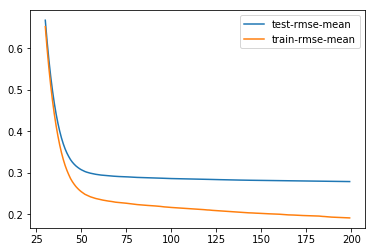

In [21]:
mpl.rcParams['figure.facecolor'] = 'w'
axes = model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [22]:
start = time.time()
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1) #the params were tuned using xgb.cv
XGBR = model_xgb.fit(processed_train, total_price)
print(XGBR)
print("time elapsed: ", (time.time() - start)," sec")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
time elapsed:  156.9492208957672  sec


In [24]:
xgb_preds = np.expm1(model_xgb.predict(processed_test))
xgb_preds[:5]

array([22040240. ,  4633598.5, 11003228. ,  6634988.5,  1021882.6],
      dtype=float32)

In [25]:
test = pd.read_csv('test.csv')

In [26]:
test.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.462231
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.819809
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.800543
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.213095


In [27]:
my_submission = pd.DataFrame({'building_id': test.building_id, 'total_price': xgb_preds})
my_submission.to_csv('submission.csv', index=False)